チャンネル数: 1
サンプル幅: 2
サンプリング周波数: 44100
フレーム数: 141480
パラメータ: _wave_params(nchannels=1, sampwidth=2, framerate=44100, nframes=141480, comptype='NONE', compname='not compressed')
長さ（秒）: 3.2081632653061223


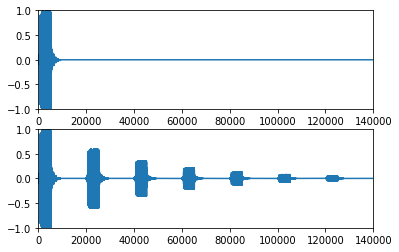

MAX:32510,MIN:-32766
b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\x02\xfe\x02\xfd\x02\xfd\x02\xfe\x02\xfe\x02\xff\x02\xff\x00\x00\x00\x00\xfe\x00\xfe\x01\xfe\x01\xfe\x01\xfe\x01\xfe\x01\xfe\x00\x00\x00\x02\xff\x02\xfe\x02\xfe\x02\xfd\x02\xfd\x02\xfd\x02\xfd\x02\xff\x00\x00\xfe\x00\xfe\x01\xfe\x01\xfe\x02\xfe\x01\xfe\x01\xfe\x00\x00\x00\x02\xff\x02\xff\x02\xfe\x02\xfc\x02\xfa\x02\xfa\x02\xfb\x02\xfd\x02\xfe\x02\xfe\x00\x00\x00\x00\xfe\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xff\x02\xfe\x02\xfd\x02\xfd\x02\xfd\x02\xfe\x02\xfe\x02\xfd\x02\xfe\x02\xff\x00\x00\x00\x00\x00\x00\x00\x00\xfe\x00\xfe\x00\xfe\x00\x02\xff\x02\xfe\x02\xfe\x02\xfe\x02\xfc\x02\xfc\x02\xfd\x00\x00\xfe\x00\x00\x00\x02\xff\x02\xff\x00\x00\xfe\x00\xfe\x00\x02\xfe\x02\xfd\x02\xfe\x02\xff\xfe\x00\xfe\x00\x02\xfd\x02\xfd\x00\x00\xfe\x00\xfe\x01\xfe\x00\x02\xff\x02\xff\x02\xff\x02\xfe\x02\xfe\x00\x00\xfe\x00\xfe\x00\x00\x00\x02\xff\xfe\x00\xfe\x03\xfe\x01\x02\xff\x02\xfe\x02\xff\x02\xff\x02\xfe\

error: required argument is not an integer

In [2]:
import wave
import pyaudio
import struct
from pylab import *

def printWaveInfo(wf):
    """WAVEファイルの情報を取得"""
    print("チャンネル数:", wf.getnchannels())
    print("サンプル幅:", wf.getsampwidth())
    print("サンプリング周波数:", wf.getframerate())
    print("フレーム数:", wf.getnframes())
    print("パラメータ:", wf.getparams())
    print("長さ（秒）:", float(wf.getnframes()) / wf.getframerate())

def play (data, fs, bit):
    import pyaudio
    # ストリームを開く
    p = pyaudio.PyAudio()
    stream = p.open(format=pyaudio.paInt16,
                    channels=1,
                    rate=int(fs),
                    output= True)
    # チャンク単位でストリームに出力し音声を再生
    chunk = 1024
    sp = 0  # 再生位置ポインタ
    buffer = data[sp:sp+chunk]
    while buffer != b'':
        stream.write(buffer)
        sp = sp + chunk
        buffer = data[sp:sp+chunk]
    stream.close()
    p.terminate()

def save(data, fs, bit, filename):
    """波形データをWAVEファイルへ出力"""
    wf = wave.open(filename, "w")
    wf.setnchannels(1)
    wf.setsampwidth(bit / 8)
    wf.setframerate(fs)
    wf.writeframes(data)
    wf.close()

if __name__ == "__main__":
    wf = wave.open("whistle.wav", "r")
    printWaveInfo(wf)

    fs = wf.getframerate()      # サンプリング周波数
    length = wf.getnframes()    # 総フレーム数
    data = wf.readframes(length)

    data = frombuffer(data, dtype="int16") / 32768.0  # -1 - +1に正規化
    a = 0.6      # 減衰率
    d = 20000    # 遅延時間（単位：サンプル）
    repeat = 6   # リピート回数

    newdata = [0.0] * length
    for n in range(length):
        newdata[n] = data[n]
        # 元のデータに残響を加える
        for i in range(1, repeat + 1):
            m = int(n - i * d)
            if m >= 0:
                newdata[n] += (a ** i) * data[m]  # i*dだけ前のデータを減衰させた振幅を加える

    # 波形を描画
    subplot(211)
    plot(data)
    axis([0, 140000, -1.0, 1.0])
    subplot(212)
    plot(newdata)
    axis([0, 140000, -1.0, 1.0])
    show()

    # -32768 - +32767へバイナリ化してから再生
    newdata = [int(x * 32767.0) for x in newdata]
    print("MAX:{0},MIN:{1}".format(max(newdata),min(newdata)))
    newdata = struct.pack("h" * len(newdata), *newdata)
    print(newdata)
    play(newdata, fs, 16)
    save(newdata, fs, 16, "whistle_delayed.wav")